In [2]:
import sys, os
sys.path.append("../../../work2/ownutils/scriptssyn/") #update path accordingly
sys.path.append('./bin/')
import PolAB_A_allpars
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from basic import compute_synergy as compute_synergyb
import matplotlib.colors as colors

In [3]:
def compute_synergy(pars):
    mstars=[]
    for i in range(4):
        if i==0:
            A=0.0
            B=0.0
        elif i==1:
            A=2.0
            B=0.0
        elif i==2:
            A=0.0
            B=2.0
        else:
            A=1.0
            B=1.0
        m=PolAB_A_allpars.interface_GRF_PolAB_A_A(pars.copy(),np.array([B]),A)
        mstars.append(m)
    SAB=np.log2(mstars[3]/mstars[1])
    SBA=np.log2(mstars[3]/mstars[2])
    if mstars[1]<mstars[2]: #due to accuracies when saving parameters, sometimes I do not recover exactly what was saved
        #print("wrong order", mstars[1],mstars[2])
        #sys.exit()
        #print("changing order")
        return None #[SBA,SAB]
    else:
        #print("Afirst")
        return [SAB,SBA]
    
sys.path.append("scripts")
import fluxes
import networkx as nx
import matplotlib as mpl

rhofunc=PolAB_A_allpars.interface_rhos_GRF_PolAB_A_A
parsliststr='ktia0,ktan0,ktin0,ktni0,ktiaA,ktanA,ktinA,ktniA,ktiaB,ktanB,ktinB,ktniB,kbBa,kuBa,kbBi,kuBi,kbBn,kuBn,kbAa,kuAa,kbAi,kuAi,kbAn,kuAn'
parslist=parsliststr.split(',')
parslist_order=['ktni0','ktin0','ktia0','ktan0','ktniA','ktinA','ktiaA','ktanA','ktniB','ktinB','ktiaB','ktanB','kbBa','kuBa','kbBi','kuBi','kbBn','kuBn','kbAa','kuAa','kbAi','kuAi','kbAn','kuAn']
flux_order_labs=['2-1','1-2','1-0','0-2','5-4','4-5','4-3','3-5','8-7','7-8','7-6','6-8','2-5','5-2','2-8','8-2','1-4','4-1','1-7','7-1','0-3','3-0','0-6','6-0']

labls=np.array(parslist[:18])
idxs_ratios=[2,3,6,7,10,11,12,13,14,15,16,17]
idxs_noratios=[0,1,4,5,8,9]
#idxs_rates=[3,2,7,6,11,10,0,4,8,1,5,9,12,13,14,15,16,17]
idxs_rates=[2,3,0,1,6,7,4,5,10,11,8,9,16,17,14,15,12,13]

#copied from 2019_05_14_prepare_3statepol-equalb

edges=[(2,'ktia0',1),(1,'ktan0',3),(2,'ktin0',3),(3,'ktni0',2),
       (8,'ktiaA',7),(7,'ktanA',9),(8,'ktinA',9),(9,'ktniA',8),
       (5,'ktiaB',4),(4,'ktanB',6),(5,'ktinB',6),(6,'ktniB',5),
      (1,'kbBa-B',4),(4,'kuBa',1),(2,'kbBi-B',5),(5,'kuBi',2),(3,'kbBn-B',6),(6,'kuBn',3),
       (1,'kbAa-A',7),(7,'kuAa',1),(2,'kbAi-A',8),(8,'kuAi',2),(3,'kbAn-A',9),(9,'kuAn',3)]
edges_=[]
for tuple_ in edges:
    edges_.append((tuple_[0]-1,tuple_[1],tuple_[2]-1))
    
graph_edges_dict=dict()
for x in edges:
    graph_edges_dict['%s-%s'%(x[0],x[2])]=x[1]

coords=fluxes.get_G_coords_9nodes()

#this is tha labels corresponding to the flux matrix, then flattened so that it is a row
nnodes=9
flux_names_mat=np.empty((nnodes,nnodes),dtype=object)
for i in np.arange(nnodes):
    for j in np.arange(nnodes):
        flux_names_mat[i,j]='%d-%d'%(i,j)
#print(flux_names_mat)
flux_names_flat=flux_names_mat.flatten()
#print(flux_names_flat)

#names of transitions for the fluxes, appending an extension to distinguish the different TF states
all_fnames=[]
flux_order_labs_AB=[]
for i in [3]:
    if i==0:
        ext='0'
    elif i==1:
        ext='A'
    elif i==2:
        ext='B'
    else:
        ext='AB'
    all_fnames.extend(['%s.%s'%(x,ext) for x in flux_names_flat]) #add extension to the labls obtained above
    flux_order_labs_AB.extend(['%s.%s'%(x,ext) for x in flux_order_labs]) #add extension to the order
all_fnames=np.array(all_fnames)

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def makeplot(parset,getsynergiesonly=False):
    node0=2
    fontsize=14
    cmapgreys=truncate_colormap(plt.cm.Greys,minval=0.2,maxval=1.0)
    cmap=cmapgreys
    idxs=range(3)
    msizes=[120,75,40,15][::-1]
    kufactors=np.array([0.1,0.5,2.5,10])
    allkufactors=np.arange(0.1,10.0,0.05)
    
    basiccoords={0: [-0.6,-0.75],
         1: [0.9,-0.25],
         2: [0, 1]}

    dx=2.5
    coords=dict()
    coords[0]=basiccoords[0]
    coords[1]=basiccoords[1]
    coords[2]=basiccoords[2]
    coords[3]=[basiccoords[0][0]+dx,basiccoords[0][1]]
    coords[4]=[basiccoords[1][0]+dx,basiccoords[1][1]]
    coords[5]=[basiccoords[2][0]+dx,basiccoords[2][1]]
    coords[6]=[basiccoords[0][0]-dx,basiccoords[0][1]]
    coords[7]=[basiccoords[1][0]-dx,basiccoords[1][1]]
    coords[8]=[basiccoords[2][0]-dx,basiccoords[2][1]]


    #connectstyles
    connectstyle1='arc3,rad=-0.45'
    connectstyle2='arc3,rad=0.2'
    connectstyle3='arc3,rad=-0.075'
    
    connectstylelist=[connectstyle1,connectstyle2,connectstyle3]
    #kuvalslist=[vlines_1458,vlines_1486]

    print(parset[0:4])
    print(parset[4:8])
    print(parset[8:12])
    print(parset[12],parset[13])
    A=1
    B=1
    netJ=True
    #kuvals=kuvalslist[idxnum]

    allGslist=[]
    allG2slist=[]
    allcolorslist=[]
    allkuvals=[]
    kuvals=[]
    synergies=[]
    allsynergies=[]
    
    GRFAB=[]
    GRFA=[]
    GRFB=[]
    GRF0=[]

    for i in range(len(allkufactors)): #kuvals)):
        #ku=kuvals[i]
        parset2=parset.copy()
        parset2[[12,14,16,18,20,22]]=parset[[12,14,16,18,20,22]]*allkufactors[i]
        
        allkuvals.append(parset2[12])
        syn=compute_synergy(parset2)
        allsynergies.append(syn)
        
        GRF0.append(PolAB_A_allpars.interface_GRF_PolAB_A_A(parset2,np.array([0]),0))
        GRFAB.append(PolAB_A_allpars.interface_GRF_PolAB_A_A(parset2,np.array([1]),1))
        GRFA.append(PolAB_A_allpars.interface_GRF_PolAB_A_A(parset2,np.array([0]),2))
        GRFB.append(PolAB_A_allpars.interface_GRF_PolAB_A_A(parset2,np.array([2]),0))
    if np.any(allsynergies==None):
        print(allsynergies)
    #print(allsynergies)
    for i in range(len(kufactors)):
        parset2=parset.copy()
        parset2[[12,14,16,18,20,22]]=parset[[12,14,16,18,20,22]]*kufactors[i]
        kuvals.append(parset2[12])
        syn=compute_synergy(parset2)
        synergies.append(syn)
        rhos=PolAB_A_allpars.interface_rhos_GRF_PolAB_A_A(parset2,np.array([B]),A)
        P=rhos/np.sum(rhos)
        J=fluxes.get_fluxes(edges_,A,B,parset2,P,netJ=netJ)
        Js_ar=J.flatten()
        #print(Js_ar)
        #keep only those columns with nonzero fluxes
        mask=[]
        for col in range(nnodes*nnodes):
            if np.any(Js_ar[col]>1e-15):
                mask.append(col)
        #mat=np.log10(all_Js)[:,mask]
        Js_ar=Js_ar[mask]
        names_ar=all_fnames[mask]
        G=fluxes.get_graph_fromJarray(np.log10(Js_ar),names_ar,min_=-15)
        Gs=[G]
        G2=fluxes.get_dominant_path_G(G,node0)
        all_G2s=[G2]
        allGslist.append(Gs)
        allG2slist.append(all_G2s)
        colors_=[[G[e[0]][e[1]]["weight"] for e in G.edges()] for G in Gs]
        allcolorslist.append(colors_)
        
    if getsynergiesonly:
        return [allsynergies,synergies,kuvals]
    else:
        
        fig,axes=plt.subplots(1,2,figsize=(7,3))
        ax=axes[1]
        synab=[x[0] for x in synergies] 
        synba=[x[1] for x in synergies]
        synaball=[x[0] for x in allsynergies] 
        synbaall=[x[1] for x in allsynergies]


        #idxs=[idxs_thisclass[]
        ax.scatter(synab,synba,edgecolors='k',facecolors='none',s=msizes) #c=range(len(kufactors)),cmap=cmap,norm=norm)
        #ax.text(synab[0],synba[0],str(idx))
        #ax.text(synab[-1],synba[-1],str(idx))
        ax.plot(synaball,synbaall,linestyle=':',color='k')
        ax.axvline(x=0,color='grey',linestyle='--')
        ax.axhline(y=0,color='grey',linestyle='--')
        ax.set_xlabel(r"$S_{A,B}$",fontsize=fontsize)
        ax.set_ylabel(r"$S_{B,A}$",fontsize=fontsize)


        ax=axes[0]
        #print("GRF0", GRF0)
        ax.plot(np.log10(allkuvals),np.array(GRFAB)/GRF0[0],color='green',label='A+B',linewidth=3)
        ax.plot(np.log10(allkuvals),np.array(GRFA)/GRF0[0],color='maroon',label='2A',linewidth=3)
        ax.plot(np.log10(allkuvals),np.array(GRFB)/GRF0[0],color='dodgerblue',label='2B',linewidth=3)
        ax.set_xlabel(r'log$_{10}$($k_b$)',fontsize=fontsize)
        ax.set_ylabel(r"fold change $m^*$",fontsize=fontsize)
        ax.tick_params(axis='both',labelsize=fontsize)
        ax.legend(loc='upper left',bbox_to_anchor=(0,0.95),ncol=3)
        ax.axhline(y=1,color='grey')
        ax.scatter(np.log10(kuvals),[1]*len(kuvals),s=msizes,edgecolors='k',facecolors='none')
        #for i in range(len(kuvals)):
        #    ax.axvline(x=np.log10(kuvals[i]),linestyle=':',color='k')
        
        #ax.set_ylim([0.25,max(np.array(GRFAB)/GRF0[0])*1.3])
        plt.tight_layout()
        plt.show()

        vmin_nflog=min([min([min(x) for x in colors_]) for colors_ in allcolorslist])
        vmax_nflog=max([max([max(x) for x in colors_]) for colors_ in allcolorslist])
        fig,axes=plt.subplots(1,4,figsize=(10,1.75))
        color_args={"edge_cmap":cmap,"edge_vmin":vmin_nflog,"edge_vmax":vmax_nflog,"width":5}

        for i in range(len(kuvals)):
            axes[i].set_title("$k_b=%2.2f$"%(kuvals[i]))
            Gs=allGslist[i]
            all_G2s=allG2slist[i]
            colors_=allcolorslist[i]
            fluxes.plot_graphs(Gs,[axes[i]],coords=coords,dominant=all_G2s,color_lists=colors_,color_args=color_args)
        cbax=fig.add_axes([1,0,0.015,1])
        norm=mpl.colors.Normalize(vmin=vmin_nflog,vmax=vmax_nflog)
        mpl.colorbar.ColorbarBase(cbax,cmap=cmap,norm=norm,ticks=np.arange(vmin_nflog,vmax_nflog,1),label="Log10 net probability flux")
        plt.tight_layout()
        plt.show()

In [4]:
green="#c6cdad"
blue="#d3dbe4"
red="#e3cbc8"
mpl.rcParams["font.size"]=14
def tint_ax(ax):
    xmin,xmax=ax.get_xlim()
    ymin,ymax=ax.get_ylim()
    if xmax>0:
        ax.fill_between([0,xmax],ymax,color=green,zorder=1)
    if xmin<0:
        ax.fill_between([xmin,0],ymax,color=blue,zorder=1)
        ax.fill_between([xmin,0],ymin,color=red,zorder=1)
    ax.set_xlim(xmin,xmax)
    ax.set_ylim(ymin,ymax)
    return ax

[2.97272098 2.8218435 ]
['' 'nnd' 'nndd' 'nndi' 'nni' 'nnid' 'nnii' 'npid' 'npii' 'pndd' 'pndi'
 'ppd' 'ppdd' 'ppdi' 'ppi' 'ppid' 'ppii']
5460
['' 'nnd' 'nndd' 'nndi' 'nni' 'nnid' 'nnii' 'npid' 'npii' 'pndd' 'pndi'
 'ppd' 'ppdd' 'ppdi' 'ppi' 'ppid' 'ppii']
class nndd
class nndi
class nnid
class nnii
class npid
class npii
class pndd
class pndi
class ppdd
class ppdi
class ppid
class ppii


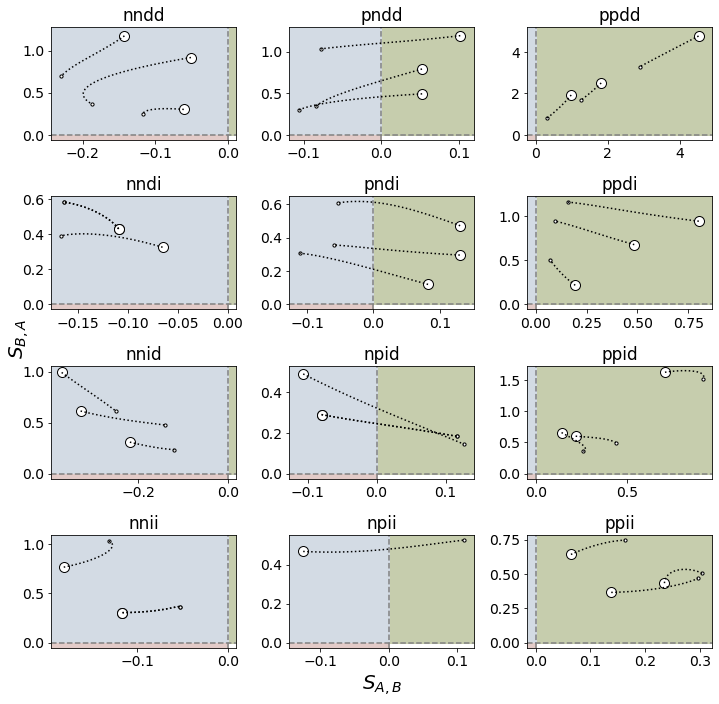

In [6]:
#find examples of all classes
nplot=10
allkufactors=np.logspace(-1,1,50)[::-1] #start from high affinity and end up at low
bins_=[[0,4],[0,4],[0,4],[1,3],[1,3],[0,4]]
parfc=3
alluc=[]
potential_classes=["nndd","pndd","ppdd","nndi","pndi","ppdi","nnid","npid","ppid","nnii","npii","ppii"]

i_=5460
np.random.seed(i_)
kb=np.random.uniform(bins_[3][0],bins_[3][1])
ku=np.random.uniform(bins_[4][0],bins_[4][1])
b_u=np.array([kb,ku])
print(b_u)
ktia0=np.random.uniform(bins_[0][0],bins_[0][1])
ktan0=np.random.uniform(bins_[1][0],bins_[1][1])
ktni0=np.random.uniform(bins_[2][0],bins_[2][1])
ktin0=np.random.uniform(bins_[5][0],bins_[5][1])

signs=[]
stop=False
j=0
while stop is False and j<50000:
    j+=1

    cont=True

    ktiaA,ktiaB=np.random.uniform(ktia0,min(4,parfc+ktia0),size=2)
    ktanA,ktanB=np.random.uniform(ktan0,min(4,parfc+ktan0),size=2)
    ktniA,ktniB=np.random.uniform(ktni0,min(4,parfc+ktni0),size=2)
    ktinA,ktinB=np.random.uniform(max(0,ktin0-parfc),ktin0,size=2)

    fullpars=10**np.concatenate((np.array([ktia0,ktan0,ktin0,ktni0,ktiaA,ktanA,ktinA,ktniA,ktiaB,ktanB,ktinB,ktniB]),np.tile(b_u,6)))


    synergies=[]
    for i in range(len(allkufactors)):
        parset2=fullpars.copy()
        parset2[[12,14,16,18,20,22]]=parset2[[12,14,16,18,20,22]]*allkufactors[i]
        #print(parset2)
        syn0=compute_synergyb(parset2,PolAB_A_allpars.interface_GRF_PolAB_A_A,fcind=5,fcpair=5)
        if syn0[0]==None:
            cont=False
            break
        else:
            synergies.append(syn0)

    if cont:

        synab=np.array([x[0] for x in synergies]) 
        synba=np.array([x[1] for x in synergies])
        tol=0.05
        if np.max(synab)-np.min(synab)>0.05 and np.max(synba)-np.min(synba)>0.05:
            SAB0=synab[0]
            SAB1=synab[-1]
            SBA0=synba[0]
            SBA1=synba[-1]

            class_=""
            plot=True

            if SAB0>tol and SAB1>tol:
                if SAB1-SAB0 >tol: 
                    class_="ppi"
                elif SAB1-SAB0<-tol:
                    class_="ppd"
            elif SAB0<-tol and SAB1>tol:
                    class_="npi"
            elif SAB0>tol and SAB1<-tol:    
                    class_="pnd"
            elif SAB0<-tol and SAB1<-tol:
                if SAB1-SAB0 >tol: 
                    class_="nni"
                elif SAB1-SAB0<-tol:
                    class_="nnd"

                #print("unknown class", SAB0, SAB1)
            if class_ != "":
                if SBA1-SBA0 > tol:
                    class_+="i"
                elif SBA1-SBA0<-tol:
                    class_+="d"
            signs.append([class_,fullpars])
            #if synab[0]>0 and synab[-1]<0:
            #    signs.append(["d",fullpars])
            #elif synab[0]<0 and synab[-1]>0:
            #    signs.append(["i",fullpars])
    classes=[s[0] for s in signs]
    uc=np.unique(classes)
    if j>10000:
        if len(uc)<10:
            stop =True
print(uc)

if len(uc)>4:
    alluc.append([uc,signs])
if len(uc)>10:
    print(i_)
    print(uc)
    #alluc.append([uc,signs])
    ncol=3
    nrow=4
    fig,axes=plt.subplots(4,3,figsize=(10,10))
    for cn,class_ in enumerate(uc):
        #if True:
        if class_ in potential_classes:
            axidx=potential_classes.index(class_)
            ax=axes[axidx//ncol][axidx%ncol]
            ax.set_title(class_)

            print("class",class_)
            parsets=[s[1] for s in signs if s[0]==class_]

            if len(parsets)>3:
                sample1=np.random.choice(np.arange(len(parsets)),size=3)
            else:
                sample1=np.arange(len(parsets))


            for idx in sample1:
                #print(idx)
                fullpars=parsets[idx]
                #makeplot(parsets[idx])
                synergies=[]
                cont=True
                for i in range(len(allkufactors)):
                    parset2=fullpars.copy()
                    parset2[[12,14,16,18,20,22]]=parset2[[12,14,16,18,20,22]]*allkufactors[i]
                    #print(parset2)
                    syn0=compute_synergyb(parset2,PolAB_A_allpars.interface_GRF_PolAB_A_A,fcind=10,fcpair=10)
                    if syn0[0]==None:
                        cont=False
                        break
                    else:
                        synergies.append(syn0)

                if cont:
                    synab=np.array([x[0] for x in synergies]) 
                    synba=np.array([x[1] for x in synergies])
                    ax.plot(synab,synba,linestyle=":",color="k",zorder=3)
                    ax.scatter(synab[0],synba[0],s=100,color='white',edgecolor='k',zorder=3)
                    ax.scatter(synab[-1],synba[-1],s=10,color='white',edgecolor='k',zorder=3)
            #ax.set_xlabel('$S_{A,B}$')
            #ax.set_ylabel('$S_{B,A}$')
            ax.axvline(x=0,linestyle='--',color='gray')
            ax.axhline(y=0,linestyle='--',color='gray')
            ax=tint_ax(ax)
    ax=axes[3,1]
    ax.set_xlabel("$S_{A,B}$",fontsize=20)
    #ax.set_ylabel("$S_{B,A}$")
    fig.text(0,0.5,"$S_{B,A}$",rotation=90,fontsize=20)
    plt.tight_layout()
    #plt.savefig("figs/Fig4Suppl2.pdf",bbox_inches="tight")
    plt.show()

    
    